In [1]:
import os, importlib, sys, time, h5py

In [2]:
import numpy as np
from scipy import io, linalg, stats, ndimage, signal
from scipy.sparse import diags

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':12})
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino'], 'size':12})
# rc('text', usetex=False)

In [4]:
import ladyns as ldn
import ladyns.inference as inf

# 1. simulate data

In [5]:
np.random.seed(12345)

In [6]:
dims = [25, 25]
num_rtime = 500
num_trial = 1000

In [7]:
coords_S = [np.array(np.where(np.full((5,5), True))).T for _ in np.arange(2)]
sigmas_S = [0.8, 0.8]
covs_S = [np.exp(-np.sum((cd[:,None,:] - cd[None,:,:])**2,-1)
                 / (2 * sigma**2))
          for cd, sigma in zip(coords_S, sigmas_S)]

## background pink noise

In [8]:
alpha = 1.4
f = np.linspace(0, np.pi, num_rtime//2+1)[1:-1]
psd = 1/(f**alpha)

In [9]:
Ws = [np.sqrt(0.5 * psd)[:,None] * 
      np.random.multivariate_normal(np.zeros(d), cov, 
            size=(num_trial, num_rtime//2-1))
      for d, cov in zip(dims, covs_S)]
RZs = [np.concatenate([
        np.random.multivariate_normal(np.zeros(d), cov, size=(num_trial,1)), 
        W, 
        np.random.multivariate_normal(np.zeros(d), cov, size=(num_trial,1)), 
        np.flip(W, axis=1)], axis=1)
       for d, W, cov in zip(dims, Ws, covs_S)]

In [10]:
Ws = [np.sqrt(0.5 * psd)[:,None] * 
      np.random.multivariate_normal(np.zeros(d), cov, 
            size=(num_trial, num_rtime//2-1))
      for d, cov in zip(dims, covs_S)]
IZs = [np.concatenate([
        np.zeros((num_trial,1,d)), 
        W, 
        np.zeros((num_trial,1,d)), 
        np.flip(W, axis=1)], axis=1)
       for W, cov, d in zip(Ws, covs_S, dims)]

In [11]:
etas = [np.fft.irfft(RZ+ 1j*IZ, num_rtime, axis=1)
        for RZ, IZ in zip(RZs, IZs)]

In [12]:
cwt_omega = 3
cwt_scales = cwt_omega * 1000 / (2 * (np.arange(100)+1) * np.pi)

In [13]:
cwt_eta_0 = [np.zeros((d, len(cwt_scales), num_rtime), dtype=np.complex128)
             for d in dims]
for k, d in enumerate(dims):
    for i in np.arange(d):
        cwt_eta_0[k][i] = signal.cwt(etas[k][0,:,i], signal.morlet2, cwt_scales, w=cwt_omega)

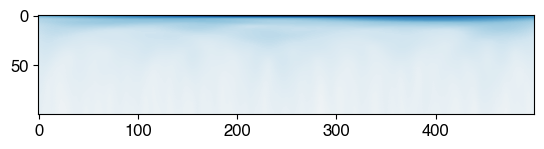

In [14]:
ldn.imshow(np.mean(np.abs(cwt_eta_0[0]),0))

In [15]:
cwt_eta = np.zeros((num_trial, len(cwt_scales), num_rtime), dtype=np.complex128)
for i in np.arange(1000):
    cwt_eta[i] = signal.cwt(etas[0][i,:,0], signal.morlet2, cwt_scales, w=cwt_omega)

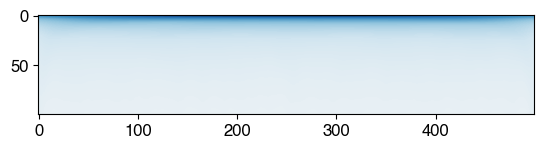

In [16]:
ldn.imshow(np.mean(np.abs(cwt_eta),0))

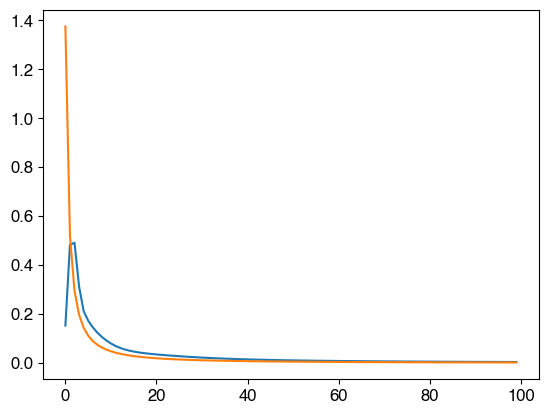

In [17]:
plt.plot(np.mean(np.abs(cwt_eta_0[0])**2, axis=(0,-1)))
plt.plot(0.003 * psd[:100])

## beta band signal

In [18]:
f_beta = 18
ts_sig = [80, 200, 400]
ss_sig = [5000/4, 5000/4, 5000/4]
pbts = [np.exp(-np.square(np.arange(num_rtime) - t)/s)
       for t, s in zip(ts_sig, ss_sig)]

In [19]:
Ws = [np.random.normal(scale=pbt, size=(num_trial,num_rtime))
      for pbt in pbts]

In [20]:
cwt_omega = 3
cwt_scale = cwt_omega * 1000 / (2 * f_beta * np.pi)

In [21]:
beta_map = signal.morlet2(num_rtime, w=cwt_omega, s=cwt_scale)

In [22]:
sigs =  [np.real(signal.convolve(W, beta_map[None,:]))
        for W in Ws]

### plots

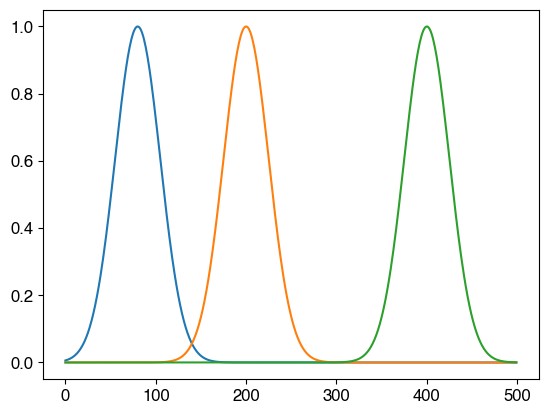

In [23]:
plt.plot(pbts[0])
plt.plot(pbts[1])
plt.plot(pbts[2])

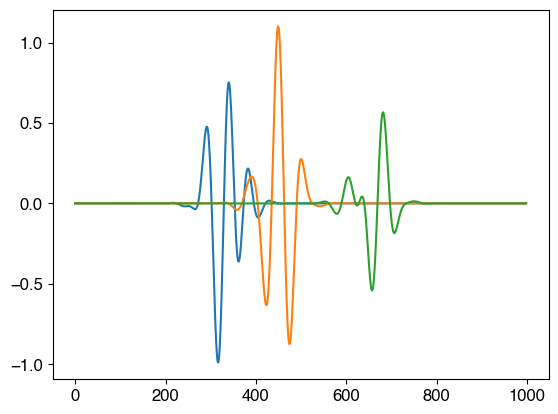

In [24]:
plt.plot(sigs[0][0])
plt.plot(sigs[1][0])
plt.plot(sigs[2][0])

In [25]:
cwt_omega = 3
cwt_scales = cwt_omega * 1000 / (2 * (np.arange(100)+1) * np.pi)

In [26]:
cwts_sig = [signal.cwt(sig[0], signal.morlet2, cwt_scales, w=cwt_omega)
           for sig in sigs]

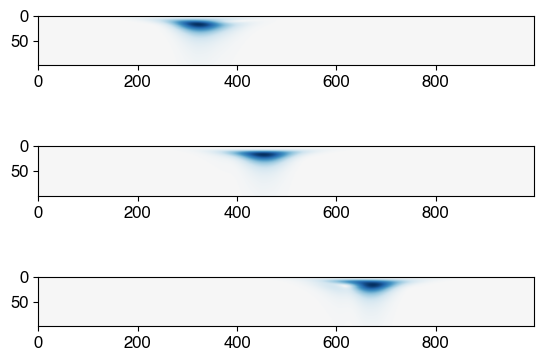

In [27]:
plt.subplot(3,1,1); ldn.imshow(np.abs(cwts_sig[0]))
plt.subplot(3,1,2); ldn.imshow(np.abs(cwts_sig[1]))
plt.subplot(3,1,3); ldn.imshow(np.abs(cwts_sig[2]))

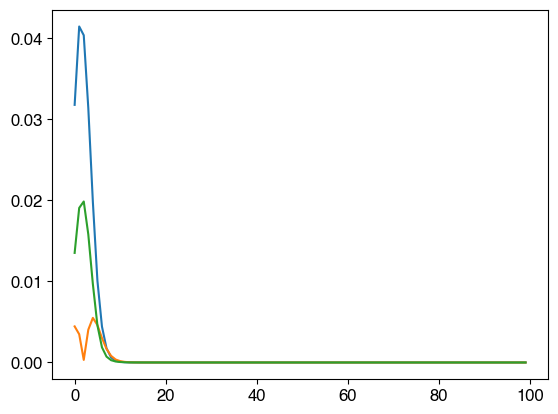

In [28]:
plt.plot(np.abs(cwts_sig[0])[:,ts_sig[0]])
plt.plot(np.abs(cwts_sig[1])[:,ts_sig[1]])
plt.plot(np.abs(cwts_sig[2])[:,ts_sig[2]])

# observation

In [29]:
ctrs = [[(2, 2), (2, 2), (2, 2)],
        [(2, 2), (2, 2), (2, 2)]]
lags = [[0, 30, 30],
        [30, 0, 0]]
ws = [[np.sqrt(0.006), np.sqrt(0.006), np.sqrt(0.006)],
      [np.sqrt(0.006), np.sqrt(0.006), np.sqrt(0.006)]]

In [30]:
betas = [[np.exp(-np.sum((cd-ct)**2,-1)/(2*sig**2))
          for ct in ctr]
         for cd, ctr, sig in zip(coords_S, ctrs, sigmas_S)] 

In [31]:
obss = [eta + w[0] * beta[0] * sigs[0][:,num_rtime//2-lag[0]:-num_rtime//2-lag[0]+1,None]
            + w[1] * beta[1] * sigs[1][:,num_rtime//2-lag[1]:-num_rtime//2-lag[1]+1,None]
            + w[2] * beta[2] * sigs[2][:,num_rtime//2-lag[2]:-num_rtime//2-lag[2]+1,None]
        for eta, beta, lag, w in zip(etas, betas, lags, ws)]

## plot

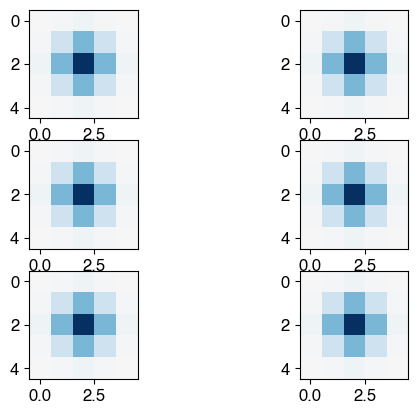

In [32]:
plt.subplot(3,2,1); ldn.imshow(betas[0][0].reshape((5,5)))
plt.subplot(3,2,2); ldn.imshow(betas[1][0].reshape((5,5)))
plt.subplot(3,2,3); ldn.imshow(betas[0][1].reshape((5,5)))
plt.subplot(3,2,4); ldn.imshow(betas[1][1].reshape((5,5)))
plt.subplot(3,2,5); ldn.imshow(betas[0][2].reshape((5,5)))
plt.subplot(3,2,6); ldn.imshow(betas[1][2].reshape((5,5)))

In [33]:
cwt_omega = 3
cwt_scales = cwt_omega * 1000 / (2 * (np.arange(100)+1) * np.pi)

In [34]:
cwt_obs = [np.zeros((d, len(cwt_scales), num_rtime), dtype=np.complex128)
           for d in dims]
for k, d in enumerate(dims):
    for i in np.arange(d):
        cwt_obs[k][i] = signal.cwt(obss[k][0,:,i], signal.morlet2, cwt_scales, w=cwt_omega)

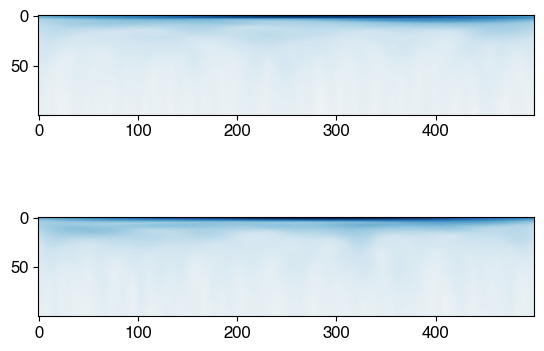

In [35]:
plt.subplot(2,1,1); ldn.imshow(np.mean(np.abs(cwt_obs[0]),0))
plt.subplot(2,1,2); ldn.imshow(np.mean(np.abs(cwt_obs[1]),0))

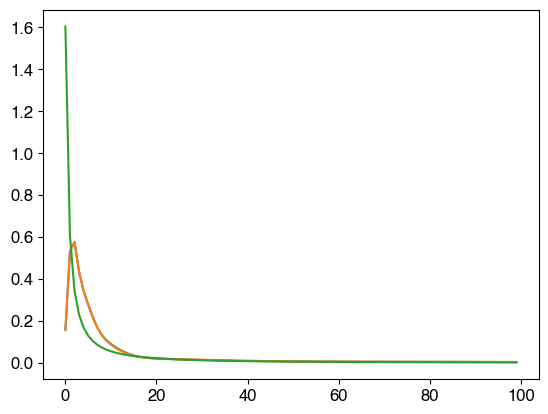

In [36]:
plt.plot(np.mean(np.abs(cwt_obs[0][:,:,400])**2,axis=0))
plt.plot(np.mean(np.abs(cwt_eta_0[0][:,:,400])**2,axis=0))
plt.plot(0.0035 * psd[:100])

# 2. pre-processing

In [37]:
cwt_omega = 3 
cwt_scale = cwt_omega * 1000 / (2 * f_beta * np.pi)

In [38]:
filter_map = signal.morlet2(num_rtime, cwt_scale, cwt_omega)

In [39]:
data = [np.zeros((num_rtime//10, d , num_trial)) for d in dims]

In [40]:
for l, d in enumerate(dims):
    for i in np.arange(d):
        data[l][:,i,:] = np.abs(signal.convolve(obss[l][:,:,i], 
                filter_map[None,:], mode='same')[:,::10]).T

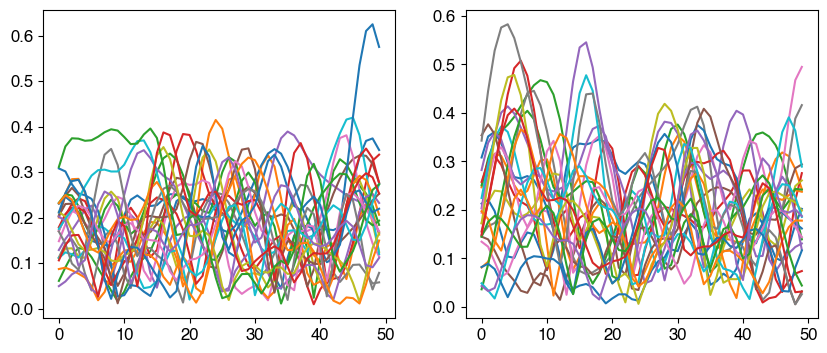

In [41]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1); plt.plot(data[0][:,:,0])
plt.subplot(1,2,2); plt.plot(data[1][:,:,0])
plt.show()

In [42]:
noise = [np.zeros((num_rtime//10, d , num_trial)) for d in dims]

In [43]:
for l, d in enumerate(dims):
    for i in np.arange(d):
        noise[l][:,i,:] = np.abs(signal.convolve(etas[l][:,:,i], 
                filter_map[None,:], mode='same')[:,::10]).T

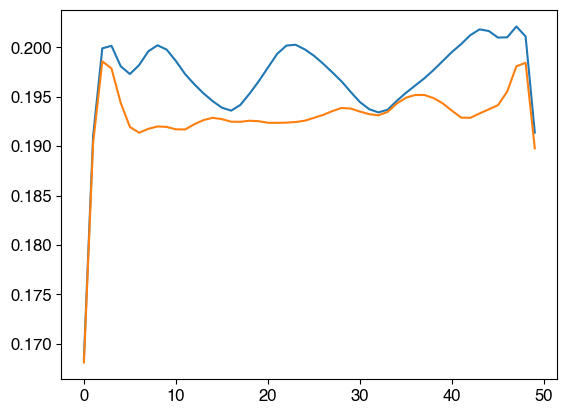

In [44]:
plt.plot(np.mean(data[0], (1,2)))
plt.plot(np.mean(noise[0], (1,2)))

In [45]:
data[0].shape, data[1].shape

((50, 25, 1000), (50, 25, 1000))

In [46]:
io.savemat('data_simulation_11.mat', {'data_0': data[0], 'data_1': data[1]})

# 3. parameter calibration

In [47]:
rec_time = [0, 500]
num_time = data[0].shape[0]

## diagonal regularization

In [48]:
cwt_omega = 3
cwt_scale = cwt_omega * 100 / (2 * f_beta * np.pi)

In [49]:
lambdas_diag = np.array([1, 2, 3, 5, 10, 20, 30, 50, 100, 200])
W_diagmean = np.zeros([len(lambdas_diag), num_time-1])
SW_ratio = np.zeros(len(lambdas_diag))
SW_error = np.zeros(len(lambdas_diag))

In [50]:
filter_mat = np.exp(-0.5*((np.arange(num_time)[:,None]
                          -np.arange(num_time))/cwt_scale)**2)
filter_mat[np.eye(num_time).astype(bool)]=0

In [51]:
for i, l_i in enumerate(lambdas_diag):
    Omegas_bar = np.concatenate([
    np.array([np.linalg.inv(np.corrcoef(dat[:,i,:]) + l_i * np.eye(num_time)) 
              for i in np.arange(d)])
    for d, dat in zip(dims, data)])
    Omegas_bar[np.array([np.eye(num_time).astype(bool)]*np.sum(dims))]=0
    
    W_diagmean[i] = np.array([
        np.mean(np.diagonal(np.mean(Omegas_bar, 0), k))
        for k in np.arange(1,num_time)
    ])
    
    SW_ratio[i] = np.sum(filter_mat*Omegas_bar) / np.sum(Omegas_bar**2)

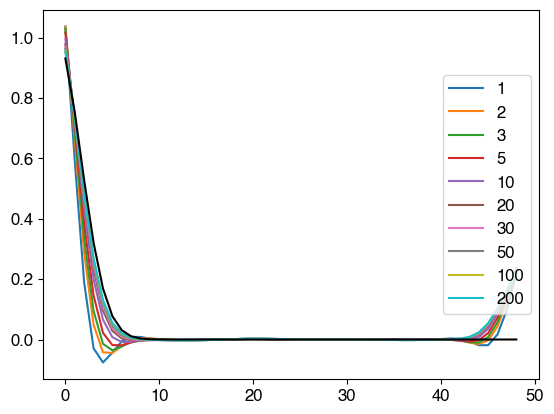

In [53]:
lineObjects = plt.plot(SW_ratio * W_diagmean.T)
plt.plot(np.exp(-0.5*(np.arange(1,num_time)/cwt_scale)**2),
         color='black')
plt.legend(list(lineObjects), lambdas_diag, loc='right')

In [54]:
np.sum((SW_ratio[:,None] * W_diagmean 
 - np.array(
     [np.mean(np.diagonal(filter_mat, k)) 
      for k in np.arange(1,num_time)]))**2, 1)

array([0.40911243, 0.2854893 , 0.22917076, 0.17668135, 0.13401946,
       0.1134327 , 0.10717467, 0.10256707, 0.09942589, 0.09798014])

## calibration by permutation

In [55]:
offset_cross=10
offset_auto=10
lambdas= np.vstack([
    np.exp(np.linspace(np.log(0.1), np.log(0.001), 11)), #np.full((11,), 0.06), ## lambdas_cross
    np.zeros(11), ## lambdas_auto
    np.full((11,), 20), ## lambdas_diag
    np.zeros(11)]) ## lambdas_ridge

In [56]:
time_graph_cross = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross)
time_graph_auto = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_auto)

In [57]:
b_time = np.linspace(rec_time[0], rec_time[1], num_time)
l_time = np.linspace(rec_time[0], rec_time[1], 2*num_time-1)

In [58]:
num_cv = 10

In [59]:
Omegas_cv = np.zeros([num_cv, lambdas.shape[-1], 2*num_time, 2*num_time])
weights_cv = []

for iter_cv in np.arange(num_cv):
    start_cv = time.time()
    
    # random sample
    trial_sample = np.random.choice(num_trial, num_trial, False)
    data_bst = [data[0], data[1][:,:,trial_sample]]

    for iter_est, (lambda_cross, lambda_auto, lambda_diag, lambda_ridge) \
    in enumerate(zip(*lambdas)): 
        if iter_cv > 0:
            init_arg = {'Omega_init': Omegas_cv[0,iter_est],
                        'weight_init': weights_cv[iter_est]}
        elif iter_est > 0:
            init_arg = {'Omega_init': Omegas_cv[0,iter_est-1],
                        'weight_init': weights_cv[iter_est-1]}
        else:
            init_arg = dict()

        Omega_est, Sigma_est, latent_est, weight_est \
        = ldn.fit(data_bst, lambda_diag, lambda_cross, offset_cross,
                   lambda_auto, offset_auto, 
                   ths_glasso=1e-6, ths_lasso=1e-6, verbose=True,
                   **init_arg)
        
        # save result
        Omegas_cv[iter_cv, iter_est] = Omega_est
        if iter_cv == 0:
            weights_cv.append(weight_est)

    sys.__stdout__.write("%d-th cv finished, lapse: %.3fsec.\n"
                         %(iter_cv+1, time.time()-start_cv))
    sys.__stdout__.flush()

1-th iter, nll: 404.100551, change: 0.190798, lapse: 0.083823
2-th iter, nll: 404.095316, change: 0.048095, lapse: 0.062981
3-th iter, nll: 404.091098, change: 0.037079, lapse: 0.098603
4-th iter, nll: 404.087430, change: 0.035220, lapse: 0.111579
5-th iter, nll: 404.084176, change: 0.031293, lapse: 0.065380
6-th iter, nll: 404.081285, change: 0.026341, lapse: 0.066563
7-th iter, nll: 404.078725, change: 0.021008, lapse: 0.085799
8-th iter, nll: 404.076468, change: 0.016012, lapse: 0.079288
9-th iter, nll: 404.074483, change: 0.013605, lapse: 0.115669
10-th iter, nll: 404.072743, change: 0.012583, lapse: 0.106771
11-th iter, nll: 404.071220, change: 0.011470, lapse: 0.114757
12-th iter, nll: 404.069890, change: 0.010332, lapse: 0.119676
13-th iter, nll: 404.068729, change: 0.009222, lapse: 0.104317
14-th iter, nll: 404.067716, change: 0.008201, lapse: 0.083125
15-th iter, nll: 404.066834, change: 0.007323, lapse: 0.070091
16-th iter, nll: 404.066065, change: 0.006711, lapse: 0.072283
1

5-th iter, nll: 404.060395, change: 0.001784, lapse: 0.077264
6-th iter, nll: 404.060358, change: 0.001412, lapse: 0.068007
7-th iter, nll: 404.060330, change: 0.001204, lapse: 0.061381
8-th iter, nll: 404.060308, change: 0.001027, lapse: 0.060729
9-th iter, nll: 404.060291, change: 0.000889, lapse: 0.065854
1-th iter, nll: 404.060667, change: 0.159746, lapse: 0.068331
2-th iter, nll: 404.060454, change: 0.005772, lapse: 0.107211
3-th iter, nll: 404.060321, change: 0.004080, lapse: 0.076464
4-th iter, nll: 404.060232, change: 0.002927, lapse: 0.069525
5-th iter, nll: 404.060168, change: 0.002189, lapse: 0.065109
6-th iter, nll: 404.060121, change: 0.001792, lapse: 0.067561
7-th iter, nll: 404.060085, change: 0.001530, lapse: 0.073441
8-th iter, nll: 404.060057, change: 0.001317, lapse: 0.064217
9-th iter, nll: 404.060034, change: 0.001149, lapse: 0.081951
10-th iter, nll: 404.060016, change: 0.001006, lapse: 0.065527
11-th iter, nll: 404.060001, change: 0.000884, lapse: 0.062036
1-th i

1-th iter, nll: 404.059984, change: 0.171473, lapse: 0.081202
2-th iter, nll: 404.059717, change: 0.005411, lapse: 0.071078
3-th iter, nll: 404.059553, change: 0.003717, lapse: 0.064902
4-th iter, nll: 404.059443, change: 0.002962, lapse: 0.099973
5-th iter, nll: 404.059364, change: 0.002394, lapse: 0.063936
6-th iter, nll: 404.059307, change: 0.001992, lapse: 0.065533
7-th iter, nll: 404.059263, change: 0.001697, lapse: 0.065457
8-th iter, nll: 404.059228, change: 0.001472, lapse: 0.077864
9-th iter, nll: 404.059201, change: 0.001278, lapse: 0.067717
10-th iter, nll: 404.059180, change: 0.001112, lapse: 0.066878
11-th iter, nll: 404.059162, change: 0.000969, lapse: 0.067940
1-th iter, nll: 404.059910, change: 0.175057, lapse: 0.071833
2-th iter, nll: 404.059625, change: 0.005605, lapse: 0.067709
3-th iter, nll: 404.059449, change: 0.003826, lapse: 0.104397
4-th iter, nll: 404.059332, change: 0.003055, lapse: 0.063543
5-th iter, nll: 404.059249, change: 0.002472, lapse: 0.064164
6-th i

5-th iter, nll: 404.058961, change: 0.002837, lapse: 0.066130
6-th iter, nll: 404.058881, change: 0.002488, lapse: 0.063114
7-th iter, nll: 404.058819, change: 0.002186, lapse: 0.064627
8-th iter, nll: 404.058769, change: 0.001921, lapse: 0.075640
9-th iter, nll: 404.058730, change: 0.001692, lapse: 0.067335
10-th iter, nll: 404.058698, change: 0.001497, lapse: 0.064534
11-th iter, nll: 404.058671, change: 0.001378, lapse: 0.063807
12-th iter, nll: 404.058649, change: 0.001267, lapse: 0.065624
13-th iter, nll: 404.058631, change: 0.001161, lapse: 0.064859
14-th iter, nll: 404.058616, change: 0.001065, lapse: 0.063651
15-th iter, nll: 404.058602, change: 0.000978, lapse: 0.088079
1-th iter, nll: 404.059731, change: 0.162323, lapse: 0.124917
2-th iter, nll: 404.059391, change: 0.006127, lapse: 0.073852
3-th iter, nll: 404.059173, change: 0.004159, lapse: 0.068151
4-th iter, nll: 404.059023, change: 0.003447, lapse: 0.065026
5-th iter, nll: 404.058913, change: 0.002899, lapse: 0.062993
6-

15-th iter, nll: 404.058595, change: 0.001438, lapse: 0.066375
16-th iter, nll: 404.058585, change: 0.001349, lapse: 0.098996
17-th iter, nll: 404.058576, change: 0.001267, lapse: 0.091269
18-th iter, nll: 404.058568, change: 0.001193, lapse: 0.103978
19-th iter, nll: 404.058561, change: 0.001125, lapse: 0.064464
20-th iter, nll: 404.058555, change: 0.001062, lapse: 0.065599
21-th iter, nll: 404.058550, change: 0.001006, lapse: 0.097293
22-th iter, nll: 404.058545, change: 0.000952, lapse: 0.061874
1-th iter, nll: 404.059560, change: 0.173105, lapse: 0.118293
2-th iter, nll: 404.059245, change: 0.006634, lapse: 0.103294
3-th iter, nll: 404.059049, change: 0.004205, lapse: 0.074871
4-th iter, nll: 404.058916, change: 0.003684, lapse: 0.065450
5-th iter, nll: 404.058821, change: 0.003317, lapse: 0.086584
6-th iter, nll: 404.058749, change: 0.003004, lapse: 0.064403
7-th iter, nll: 404.058694, change: 0.002729, lapse: 0.063945
8-th iter, nll: 404.058650, change: 0.002487, lapse: 0.063473


1-th iter, nll: 404.059235, change: 0.151986, lapse: 0.126129
2-th iter, nll: 404.058911, change: 0.008670, lapse: 0.087954
3-th iter, nll: 404.058705, change: 0.006231, lapse: 0.110174
4-th iter, nll: 404.058566, change: 0.004597, lapse: 0.072762
5-th iter, nll: 404.058468, change: 0.003642, lapse: 0.064815
6-th iter, nll: 404.058395, change: 0.003045, lapse: 0.104510
7-th iter, nll: 404.058340, change: 0.002613, lapse: 0.103600
8-th iter, nll: 404.058297, change: 0.002265, lapse: 0.065517
9-th iter, nll: 404.058263, change: 0.001978, lapse: 0.070577
10-th iter, nll: 404.058236, change: 0.001751, lapse: 0.106228
11-th iter, nll: 404.058214, change: 0.001564, lapse: 0.064956
12-th iter, nll: 404.058196, change: 0.001413, lapse: 0.063205
13-th iter, nll: 404.058181, change: 0.001279, lapse: 0.079984
14-th iter, nll: 404.058168, change: 0.001161, lapse: 0.065236
15-th iter, nll: 404.058158, change: 0.001056, lapse: 0.063884
16-th iter, nll: 404.058149, change: 0.000964, lapse: 0.063035
1

6-th iter, nll: 404.059292, change: 0.002893, lapse: 0.117850
7-th iter, nll: 404.059240, change: 0.002622, lapse: 0.100559
8-th iter, nll: 404.059198, change: 0.002377, lapse: 0.064123
9-th iter, nll: 404.059164, change: 0.002154, lapse: 0.065931
10-th iter, nll: 404.059136, change: 0.001959, lapse: 0.065437
11-th iter, nll: 404.059113, change: 0.001786, lapse: 0.087376
12-th iter, nll: 404.059093, change: 0.001638, lapse: 0.100518
13-th iter, nll: 404.059076, change: 0.001505, lapse: 0.062057
14-th iter, nll: 404.059061, change: 0.001386, lapse: 0.093045
15-th iter, nll: 404.059049, change: 0.001275, lapse: 0.062548
16-th iter, nll: 404.059038, change: 0.001180, lapse: 0.073198
17-th iter, nll: 404.059028, change: 0.001120, lapse: 0.092291
18-th iter, nll: 404.059020, change: 0.001062, lapse: 0.093397
19-th iter, nll: 404.059013, change: 0.001006, lapse: 0.063014
20-th iter, nll: 404.059006, change: 0.000953, lapse: 0.085318
1-th iter, nll: 404.059893, change: 0.163867, lapse: 0.1264

1-th iter, nll: 404.060414, change: 0.123852, lapse: 0.114297
2-th iter, nll: 404.060246, change: 0.005224, lapse: 0.069148
3-th iter, nll: 404.060139, change: 0.003967, lapse: 0.071998
4-th iter, nll: 404.060065, change: 0.003607, lapse: 0.255435
5-th iter, nll: 404.060010, change: 0.003637, lapse: 0.103495
6-th iter, nll: 404.059967, change: 0.003425, lapse: 0.063522
7-th iter, nll: 404.059934, change: 0.003130, lapse: 0.062199
8-th iter, nll: 404.059907, change: 0.002835, lapse: 0.061842
9-th iter, nll: 404.059885, change: 0.002543, lapse: 0.060356
10-th iter, nll: 404.059866, change: 0.002290, lapse: 0.077661
11-th iter, nll: 404.059851, change: 0.002052, lapse: 0.062069
12-th iter, nll: 404.059837, change: 0.001838, lapse: 0.060727
13-th iter, nll: 404.059826, change: 0.001647, lapse: 0.060828
14-th iter, nll: 404.059816, change: 0.001482, lapse: 0.060556
15-th iter, nll: 404.059808, change: 0.001336, lapse: 0.069668
16-th iter, nll: 404.059800, change: 0.001207, lapse: 0.061027
1

17-th iter, nll: 404.058643, change: 0.001349, lapse: 0.084434
18-th iter, nll: 404.058633, change: 0.001236, lapse: 0.063514
19-th iter, nll: 404.058623, change: 0.001133, lapse: 0.085248
20-th iter, nll: 404.058615, change: 0.001030, lapse: 0.104192
21-th iter, nll: 404.058608, change: 0.000961, lapse: 0.076234
8-th cv finished, lapse: 13.110sec.
1-th iter, nll: 404.060878, change: 0.003074, lapse: 0.094449
2-th iter, nll: 404.060859, change: 0.000805, lapse: 0.094429
1-th iter, nll: 404.060769, change: 0.047150, lapse: 0.061804
2-th iter, nll: 404.060761, change: 0.000705, lapse: 0.077823
1-th iter, nll: 404.060765, change: 0.095070, lapse: 0.112449
2-th iter, nll: 404.060723, change: 0.002087, lapse: 0.063279
3-th iter, nll: 404.060696, change: 0.001196, lapse: 0.065414
4-th iter, nll: 404.060678, change: 0.000790, lapse: 0.069630
1-th iter, nll: 404.060776, change: 0.129720, lapse: 0.065643
2-th iter, nll: 404.060666, change: 0.003243, lapse: 0.086544
3-th iter, nll: 404.060597, c

3-th iter, nll: 404.060720, change: 0.002766, lapse: 0.102395
4-th iter, nll: 404.060672, change: 0.002119, lapse: 0.061363
5-th iter, nll: 404.060639, change: 0.001687, lapse: 0.088710
6-th iter, nll: 404.060614, change: 0.001386, lapse: 0.060676
7-th iter, nll: 404.060595, change: 0.001159, lapse: 0.072622
8-th iter, nll: 404.060581, change: 0.000982, lapse: 0.071796
1-th iter, nll: 404.060889, change: 0.130584, lapse: 0.088621
2-th iter, nll: 404.060723, change: 0.004505, lapse: 0.065355
3-th iter, nll: 404.060619, change: 0.003581, lapse: 0.084789
4-th iter, nll: 404.060548, change: 0.002744, lapse: 0.085675
5-th iter, nll: 404.060498, change: 0.002183, lapse: 0.062870
6-th iter, nll: 404.060462, change: 0.001792, lapse: 0.077875
7-th iter, nll: 404.060434, change: 0.001498, lapse: 0.083115
8-th iter, nll: 404.060413, change: 0.001268, lapse: 0.061252
9-th iter, nll: 404.060396, change: 0.001085, lapse: 0.077816
10-th iter, nll: 404.060383, change: 0.000937, lapse: 0.062462
1-th it

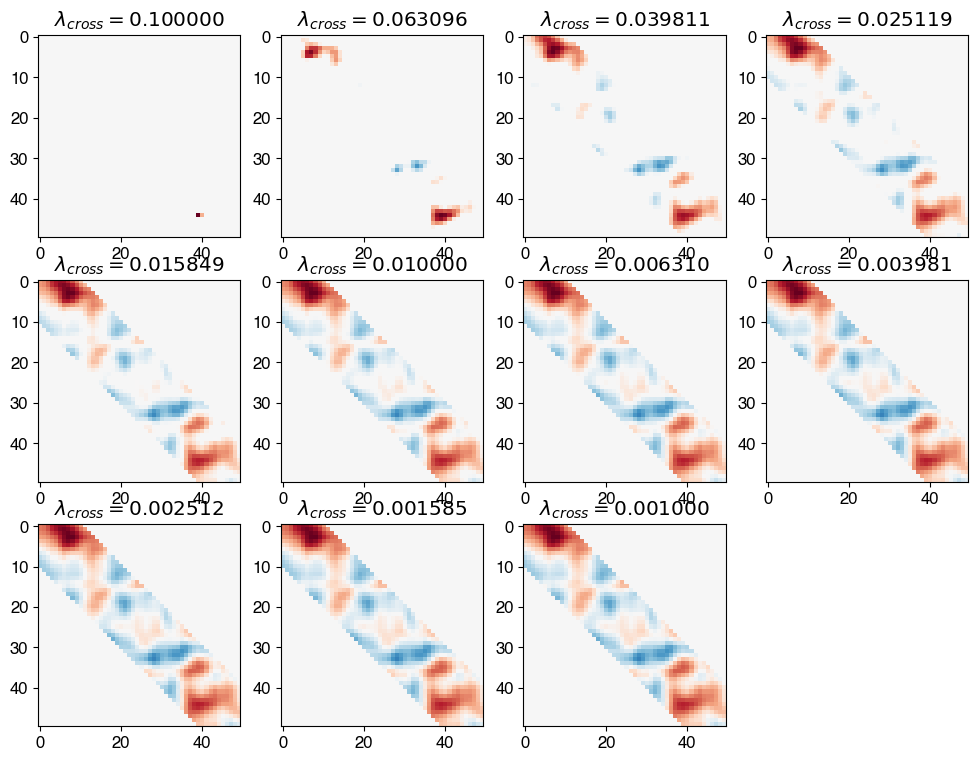

In [60]:
plt.figure(figsize=(12,3*int(lambdas.shape[-1]/4+1)))
for iter_lambda, (lambda_cross, lambda_auto, lambda_diag, lambda_ridge) \
in enumerate(zip(*lambdas)):
    plt.subplot(int(lambdas.shape[-1]/4+1), 4, iter_lambda+1)
    ldn.imshow(Omegas_cv[0, iter_lambda,:num_time,num_time:], identity=True)
    plt.title(r'$\lambda_{cross} = %f$'%lambda_cross)

In [61]:
fds_cv = np.sum(Omegas_cv[:,:,:num_time,num_time:]!=0,(0,-2,-1))/num_cv
fdrs_cv = np.sum(Omegas_cv[:,:,:num_time,num_time:]!=0,(0,-2,-1))/np.sum(time_graph_cross)/num_cv

Text(0, 0.5, 'mean false discovery')

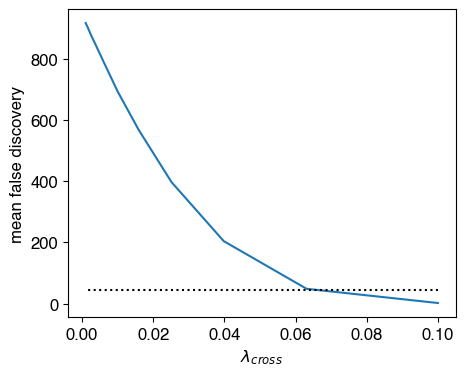

In [62]:
plt.figure(figsize=(5,4))
plt.plot(lambdas[0], fds_cv)
plt.plot(lambdas[0], np.full(lambdas[0].shape, 0.05*np.sum(time_graph_cross)), color='black', linestyle=':')
plt.xlabel(r"$\lambda_{cross}$")
plt.ylabel(r"mean false discovery")

In [63]:
id_cv = np.argmax(fdrs_cv[fdrs_cv < 0.05])

In [64]:
lambda_cross, lambda_auto, lambda_diag, lambda_ridge = lambdas.T[id_cv]
lambda_cross, lambda_auto, lambda_diag, lambda_ridge

(0.10000000000000002, 0.0, 20.0, 0.0)

In [65]:
# lambda_cross, lambda_auto, lambda_diag, lambda_ridge = (0.02, 0, 1, 0) 

# 4. LaDynS

In [66]:
lambda_graph = np.array(np.block(
    [[(1+lambda_auto)*(time_graph_auto-np.eye(num_time)) + (1+lambda_diag)*np.eye(num_time), (1+lambda_cross)*time_graph_cross],
     [(1+lambda_cross)*time_graph_cross, (1+lambda_auto)*(time_graph_auto-np.eye(num_time)) + (1+lambda_diag)*np.eye(num_time)]])) -1

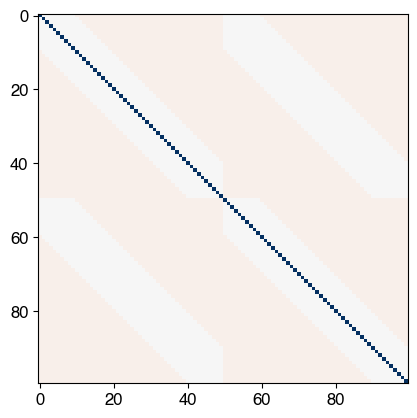

In [67]:
ldn.imshow(lambda_graph)

In [68]:
S_xt = np.cov(*[dat.transpose([1,0,2]).reshape([d,-1])
                for dat, d in zip(data, dims)])
S_1 = S_xt[:dims[0],:dims[0]]
S_12 = S_xt[:dims[0],dims[0]:]
S_2 = S_xt[dims[0]:,dims[0]:]

U_1= linalg.inv(linalg.sqrtm(S_1))
U_2 = linalg.inv(linalg.sqrtm(S_2))

u, s, vh = np.linalg.svd(U_1 @ S_12 @ U_2)
weight_init = [(U_1 @ u[:,0]).copy() for _ in np.arange(num_time)] \
            + [ (U_2 @ vh[0]).copy() for _ in np.arange(num_time)]

In [69]:
Omega_est, Sigma_est, latent_est, weight_est =\
    ldn.fit(data, lambda_diag, lambda_cross, offset_cross,
            lambda_auto, offset_auto, 
            ths_glasso=1e-6, ths_lasso=1e-6, verbose=True)

1-th iter, nll: 404.100551, change: 0.190798, lapse: 0.067979
2-th iter, nll: 404.095316, change: 0.048095, lapse: 0.081514
3-th iter, nll: 404.091098, change: 0.037079, lapse: 0.063119
4-th iter, nll: 404.087425, change: 0.035220, lapse: 0.061282
5-th iter, nll: 404.084137, change: 0.031293, lapse: 0.065204
6-th iter, nll: 404.081170, change: 0.026341, lapse: 0.062535
7-th iter, nll: 404.078475, change: 0.021013, lapse: 0.111993
8-th iter, nll: 404.076023, change: 0.017823, lapse: 0.065739
9-th iter, nll: 404.073791, change: 0.017876, lapse: 0.098079
10-th iter, nll: 404.071765, change: 0.017906, lapse: 0.067287
11-th iter, nll: 404.069937, change: 0.017736, lapse: 0.067923
12-th iter, nll: 404.068302, change: 0.017022, lapse: 0.098571
13-th iter, nll: 404.066849, change: 0.016137, lapse: 0.121122
14-th iter, nll: 404.065569, change: 0.014864, lapse: 0.061326
15-th iter, nll: 404.064450, change: 0.013447, lapse: 0.061929
16-th iter, nll: 404.063477, change: 0.011944, lapse: 0.062102
1

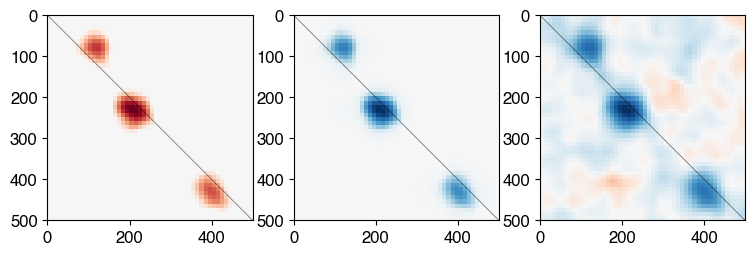

In [70]:
plt.figure(figsize=(9,3))
plt.subplot(1,3,1); ldn.imshow(Omega_est[:num_time,num_time:], time=rec_time, identity=True)
plt.subplot(1,3,2); ldn.imshow(linalg.inv(Omega_est)[:num_time,num_time:], time=rec_time, identity=True)
plt.subplot(1,3,3); ldn.imshow(Sigma_est[:num_time,num_time:], time=rec_time, identity=True)

In [71]:
dspr_est = 2*Omega_est - Omega_est @ (Sigma_est + lambda_diag*np.eye(2*num_time)) @ Omega_est

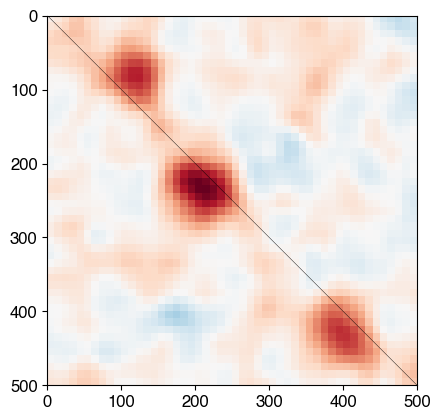

In [72]:
ldn.imshow(dspr_est[:num_time,num_time:],
           time=rec_time, identity=True)

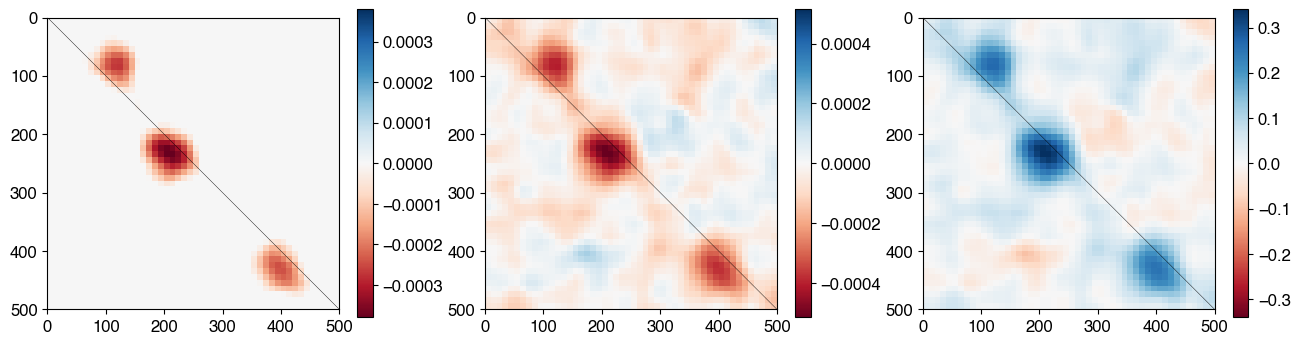

In [73]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1); ldn.imshow(Omega_est[:num_time, num_time:], time=rec_time, identity=True); plt.colorbar()
plt.subplot(1,3,2); ldn.imshow(dspr_est[:num_time, num_time:], time=rec_time, identity=True); plt.colorbar()
plt.subplot(1,3,3); ldn.imshow(Sigma_est[:num_time, num_time:], time=rec_time, identity=True); plt.colorbar()

Text(0, 0.5, 'series 1 at time $t$')

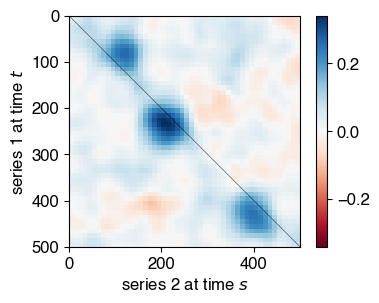

In [74]:
plt.figure(figsize=(4,3))
ldn.imshow(Sigma_est[:num_time,num_time:], time=rec_time, identity=True); plt.colorbar()
plt.xlabel(r"series 2 at time $s$"); plt.ylabel(r"series 1 at time $t$")

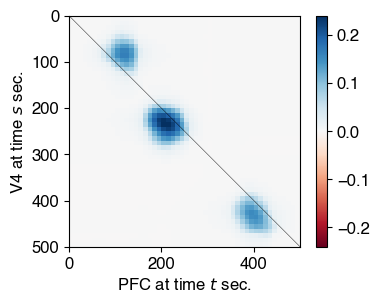

In [75]:
plt.figure(figsize=(4,3))
ldn.imshow(np.linalg.inv(Omega_est)[:num_time,num_time:], time=rec_time, identity=True)
plt.xlabel(r"PFC at time $t$ sec."); plt.ylabel(r"V4 at time $s$ sec.")
plt.colorbar()

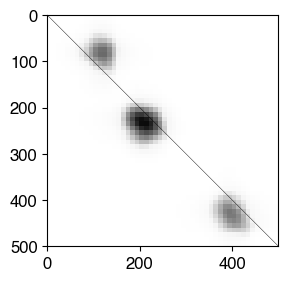

In [76]:
plt.figure(figsize=(3,3))
ldn.imshow(np.abs(np.linalg.inv(Omega_est)[:num_time,num_time:]), 
           time=rec_time, identity=True, 
           vmin=0, vmax=0.25, cmap='Greys')
# plt.xlabel(r"PFC at time $t$ sec."); plt.ylabel(r"V4 at time $s$ sec.")
# plt.colorbar()

# 5. Permutation test

In [77]:
num_perm = 200

In [78]:
init_arg = {'Omega_init': Omegas_cv[0,id_cv],
            'weight_init': weights_cv[id_cv]}

In [79]:
Omegas_perm = np.zeros([num_perm, 2*num_time, 2*num_time])
Sigmas_perm = np.zeros([num_perm, 2*num_time, 2*num_time])

for iter_perm in range(num_perm):    
    while True:
        with np.errstate(all='raise'):
            try:
                start_perm = time.time()
                
                # random sample
                trial_sample = np.random.choice(num_trial, num_trial, False)
                data_bst = [data[0], data[1][:,:,trial_sample]]

                # permutation
                Omega_perm, Sigma_perm, latent_perm, weight_perm \
                = ldn.fit(data_bst, lambda_diag, lambda_cross, offset_cross,
                          lambda_auto, offset_auto, 
                          ths_glasso=1e-6, ths_lasso=1e-6, verbose=True,
                          **init_arg)
        
                
            except FloatingPointError:
                sys.__stdout__.write("%d-th permutation encountered FloatingPointError, lapse:%.3fsec.\n"
                                     %(iter_perm+1, time.time()-start_perm))
                sys.__stdout__.write("Retrying...\n")
                sys.__stdout__.flush()
                continue
                
            init_arg = {'Omega_init':Omega_perm, 'weight_init':weight_perm}
                        
            # save result
            Omegas_perm[iter_perm] = Omega_perm
            Sigmas_perm[iter_perm] = Sigma_perm
            
            sys.__stdout__.write("%d-th permutation finished, lapse: %.3fsec.\n"
                          %(iter_perm+1, time.time()-start_perm))
            sys.__stdout__.flush()
            break

1-th iter, nll: 404.060878, change: 0.003074, lapse: 0.067225
2-th iter, nll: 404.060859, change: 0.000805, lapse: 0.086661
1-th permutation finished, lapse: 0.167sec.
1-th iter, nll: 404.060841, change: 0.016749, lapse: 0.101238
2-th iter, nll: 404.060826, change: 0.001114, lapse: 0.065790
3-th iter, nll: 404.060813, change: 0.000771, lapse: 0.076226
2-th permutation finished, lapse: 0.256sec.
1-th iter, nll: 404.060803, change: 0.018635, lapse: 0.097248
2-th iter, nll: 404.060793, change: 0.000566, lapse: 0.095205
3-th permutation finished, lapse: 0.204sec.
1-th iter, nll: 404.060784, change: 0.013582, lapse: 0.089179
2-th iter, nll: 404.060777, change: 0.000492, lapse: 0.091579
4-th permutation finished, lapse: 0.193sec.
1-th iter, nll: 404.060770, change: 0.000459, lapse: 0.065625
5-th permutation finished, lapse: 0.078sec.
1-th iter, nll: 404.060764, change: 0.000434, lapse: 0.061108
6-th permutation finished, lapse: 0.073sec.
1-th iter, nll: 404.060758, change: 0.000409, lapse: 0

1-th iter, nll: 404.060715, change: 0.000011, lapse: 0.059356
57-th permutation finished, lapse: 0.071sec.
1-th iter, nll: 404.060715, change: 0.000009, lapse: 0.078059
58-th permutation finished, lapse: 0.090sec.
1-th iter, nll: 404.060715, change: 0.008616, lapse: 0.079097
2-th iter, nll: 404.060715, change: 0.000222, lapse: 0.060435
59-th permutation finished, lapse: 0.152sec.
1-th iter, nll: 404.060715, change: 0.008807, lapse: 0.059171
2-th iter, nll: 404.060715, change: 0.000031, lapse: 0.076155
60-th permutation finished, lapse: 0.147sec.
1-th iter, nll: 404.060715, change: 0.000014, lapse: 0.061029
61-th permutation finished, lapse: 0.072sec.
1-th iter, nll: 404.060715, change: 0.000006, lapse: 0.081292
62-th permutation finished, lapse: 0.093sec.
1-th iter, nll: 404.060715, change: 0.010287, lapse: 0.060856
2-th iter, nll: 404.060715, change: 0.000252, lapse: 0.105063
63-th permutation finished, lapse: 0.178sec.
1-th iter, nll: 404.060715, change: 0.010539, lapse: 0.076648
2-t

1-th iter, nll: 404.060715, change: 0.000013, lapse: 0.084541
117-th permutation finished, lapse: 0.096sec.
1-th iter, nll: 404.060715, change: 0.000008, lapse: 0.070437
118-th permutation finished, lapse: 0.084sec.
1-th iter, nll: 404.060714, change: 0.015328, lapse: 0.094022
2-th iter, nll: 404.060714, change: 0.000385, lapse: 0.093906
119-th permutation finished, lapse: 0.200sec.
1-th iter, nll: 404.060715, change: 0.015713, lapse: 0.065396
2-th iter, nll: 404.060715, change: 0.000080, lapse: 0.064045
120-th permutation finished, lapse: 0.141sec.
1-th iter, nll: 404.060715, change: 0.000014, lapse: 0.061244
121-th permutation finished, lapse: 0.073sec.
1-th iter, nll: 404.060715, change: 0.000007, lapse: 0.083526
122-th permutation finished, lapse: 0.095sec.
1-th iter, nll: 404.060701, change: 0.038343, lapse: 0.078159
2-th iter, nll: 404.060701, change: 0.001767, lapse: 0.074343
3-th iter, nll: 404.060701, change: 0.000783, lapse: 0.091644
123-th permutation finished, lapse: 0.256s

2-th iter, nll: 404.060715, change: 0.000392, lapse: 0.065242
176-th permutation finished, lapse: 0.138sec.
1-th iter, nll: 404.060715, change: 0.013476, lapse: 0.081351
2-th iter, nll: 404.060715, change: 0.000066, lapse: 0.078377
177-th permutation finished, lapse: 0.171sec.
1-th iter, nll: 404.060715, change: 0.001731, lapse: 0.092119
2-th iter, nll: 404.060715, change: 0.000006, lapse: 0.079769
178-th permutation finished, lapse: 0.184sec.
1-th iter, nll: 404.060715, change: 0.000004, lapse: 0.067735
179-th permutation finished, lapse: 0.084sec.
1-th iter, nll: 404.060715, change: 0.000003, lapse: 0.068293
180-th permutation finished, lapse: 0.080sec.
1-th iter, nll: 404.060715, change: 0.000002, lapse: 0.079547
181-th permutation finished, lapse: 0.091sec.
1-th iter, nll: 404.060715, change: 0.001774, lapse: 0.079183
2-th iter, nll: 404.060715, change: 0.000030, lapse: 0.069964
182-th permutation finished, lapse: 0.161sec.
1-th iter, nll: 404.060715, change: 0.003746, lapse: 0.076

# 6. FDR inference on Cross-precision

In [80]:
alpha = 0.05
roi = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross-1)

In [81]:
dspr_est = 2*Omega_est - Omega_est@(Sigma_est + lambda_diag*np.eye(2*num_time))@Omega_est
dsprs_perm = 2*Omegas_perm - Omegas_perm@(Sigmas_perm + lambda_diag*np.eye(2*num_time))@Omegas_perm

Text(0, 0.5, 'series 1 at time $t$ ms')

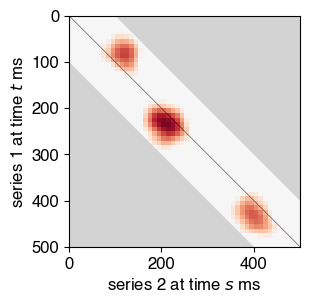

In [82]:
fig, ax = plt.subplots(figsize=(4,3))
ldn.imshow(Omega_est[:num_time,num_time:], time=rec_time, identity=True, vmax=0.0004)

ax.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
ax.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
# cbar = plt.colorbar(ticks=[-0.002, -0.001, 0.0, 0.001, 0.002])
# cbar.ax.set_yticklabels(['-2e-3','-1e-3','0','1e-3','2e-3'])
ax.set_xlim(rec_time[0], rec_time[1]); ax.set_ylim(rec_time[1], rec_time[0])
plt.xlabel(r"series 2 at time $s$ ms"); plt.ylabel(r"series 1 at time $t$ ms")

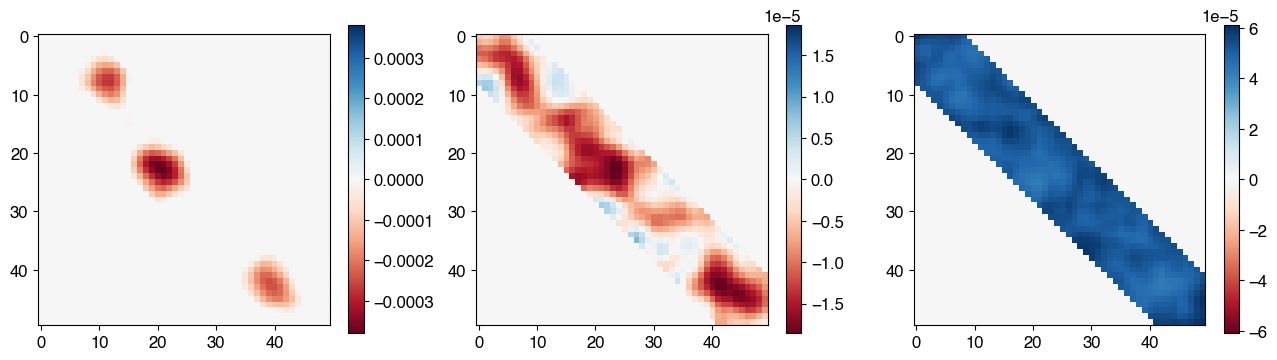

In [83]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1); ldn.imshow(Omega_est[:num_time,num_time:]*roi); plt.colorbar()
plt.subplot(1,3,2); ldn.imshow(np.mean(dsprs_perm, 0)[:num_time,num_time:]*roi); plt.colorbar()
plt.subplot(1,3,3); ldn.imshow(np.std(dsprs_perm, 0)[:num_time,num_time:]*roi); plt.colorbar()

In [84]:
dist_dspr_est = (dspr_est[:num_time,num_time:] / np.std(dsprs_perm[:,:num_time,num_time:],0))
dist_dspr_perm = (dsprs_perm[:,:num_time,num_time:]
                 / np.std(dsprs_perm[:,:num_time,num_time:],0))

In [85]:
temp = np.argsort(np.concatenate([
    np.abs(dist_dspr_est[roi]),
    np.abs(dist_dspr_perm[:,roi]).flatten()]))

ranks = np.empty_like(temp)
ranks[temp] = np.cumsum(temp > np.sum(roi))

In [86]:
pval_est = np.full(dist_dspr_est.shape, 0.5)
pvals_perm = np.full(dist_dspr_perm.shape, 0.5)
pval_est[roi] = 1-(ranks[:np.sum(roi)]/len(temp) - 1/(2*len(temp)))
pvals_perm[:,roi] = 1-(ranks[np.sum(roi):].reshape((num_perm,np.sum(roi)))/len(temp) - 1/(2*len(temp)))

In [87]:
pval_est[roi] = np.clip(2*stats.norm.cdf(-np.abs(dist_dspr_est[roi])), 1e-10, 1-1e-10)

[Text(1, 0.0, '0.00'), Text(1, 0.01, '$>$0.01')]

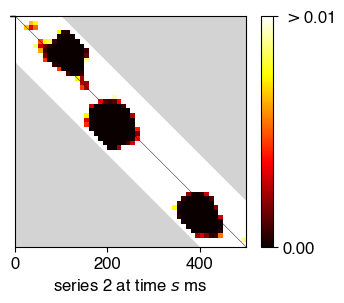

In [90]:
plt.figure(figsize=(4,3))
ldn.imshow(pval_est, cmap='hot', vmin=0, vmax=0.01, time=rec_time, identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')

plt.xlabel(r"series 2 at time $s$ ms"); # plt.ylabel(r"series 1 at time $t$")
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5], ['','','','','',''])

cbar = plt.colorbar(ticks=[0, 0.01])
cbar.ax.set_yticklabels(['0.00','$>$0.01'])

In [91]:
p_sorted = np.concatenate([[0], np.sort(pval_est[roi])])
k_hat = np.max(np.where(np.linspace(0, alpha, np.sum(roi)+1) >= p_sorted))        
rej_BH = pval_est <= k_hat * alpha / np.sum(roi)

Text(0, 0.5, 'V4 at time $s$ sec.')

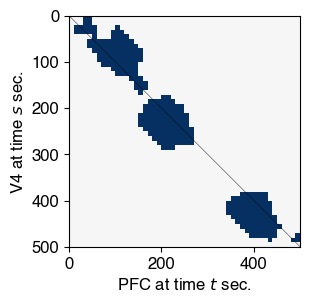

In [92]:
plt.figure(figsize=(3,3))
ldn.imshow(rej_BH * roi, time=rec_time, identity=True)
plt.xlabel(r"PFC at time $t$ sec."); plt.ylabel(r"V4 at time $s$ sec.")

([<matplotlib.axis.YTick at 0x1667b9c10>,
 [Text(0, 0.0, ''),
  Text(0, 0.1, ''),
  Text(0, 0.2, ''),
  Text(0, 0.3, ''),
  Text(0, 0.4, ''),
  Text(0, 0.5, '')])

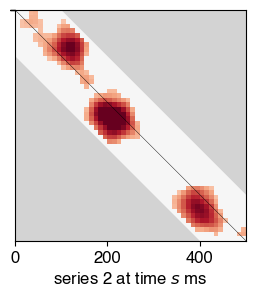

In [94]:
fig, ax = plt.subplots(figsize=(3,3))
ldn.imshow(rej_BH * dspr_est[:num_time,num_time:], time=rec_time, identity=True, vmax=0.0004)

ax.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
ax.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
# cbar = plt.colorbar(ticks=[-0.001, -0.0005, 0.0, 0.0005, 0.001])
# cbar.ax.set_yticklabels(['-2e-3','-1e-3','0','1e-3','2e-3'])
ax.set_xlim(rec_time[0], rec_time[1]); ax.set_ylim(rec_time[1], rec_time[0])
plt.xlabel(r"series 2 at time $s$ ms"); # plt.ylabel(r"series 1 at time $t$")
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5], ['','','','','',''])

## excursion test

In [95]:
ths_nv = k_hat * alpha / np.sum(roi)

In [96]:
rej_nv = pval_est <= ths_nv
rejs_nv_perm = pvals_perm < ths_nv

In [97]:
rejs_blobs_perm = np.zeros((num_perm, num_time, num_time))
nums_blobs_perm = np.zeros((num_perm,))

for iter_perm in range(num_perm):
    mask_cp = rejs_nv_perm[iter_perm]; iter_blob = 0
    while np.any(mask_cp):
        iter_blob += 1
        queue = [tuple(np.transpose(np.where(mask_cp))[0])]
        mask_cp[queue[0]] = False
        while len(queue) > 0:
            cur = queue.pop(0)
            rejs_blobs_perm[iter_perm, cur[0], cur[1]] = iter_blob
            if cur[0] > 0:
                if mask_cp[cur[0]-1, cur[1]]:
                    queue.append((cur[0]-1, cur[1]))
                    mask_cp[cur[0]-1, cur[1]] = False
            if cur[0] < num_time-1:
                if mask_cp[cur[0]+1, cur[1]]:
                    queue.append((cur[0]+1, cur[1]))
                    mask_cp[cur[0]+1, cur[1]] = False
            if cur[1] > 0:
                if mask_cp[cur[0], cur[1]-1]:
                    queue.append((cur[0], cur[1]-1))
                    mask_cp[cur[0], cur[1]-1] = False
            if cur[1] < num_time-1:
                if mask_cp[cur[0], cur[1]+1]:
                    queue.append((cur[0], cur[1]+1))
                    mask_cp[cur[0], cur[1]+1] = False
    nums_blobs_perm[iter_perm] = iter_blob

In [98]:
mrois_nv_perm = np.zeros(num_perm)
for iter_perm, (pval, rej_b, num_b) \
in enumerate(zip(pvals_perm, rejs_blobs_perm, nums_blobs_perm)):
    rois = np.zeros(int(num_b+1))
    for iter_blob in range(1, int(num_b+1)):
        rois[iter_blob] = np.sum(-np.log(
            pvals_perm[iter_perm][rej_b == iter_blob]))
    mrois_nv_perm[iter_perm] = np.max(rois)

In [99]:
ths_roi = np.quantile(mrois_nv_perm, 0.95)

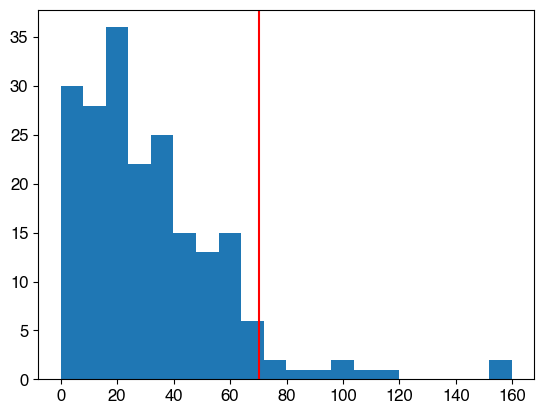

In [100]:
plt.hist(mrois_nv_perm, bins=20)
plt.axvline(x=ths_roi, color='red')

In [101]:
rej_blobs = np.zeros((num_time, num_time))

mask_cp = rej_nv; iter_blob = 0
while np.any(mask_cp):
    iter_blob += 1
    queue = [tuple(np.transpose(np.where(mask_cp))[0])]
    mask_cp[queue[0]] = False
    while len(queue) > 0:
        cur = queue.pop(0)
        rej_blobs[cur[0], cur[1]] = iter_blob
        if cur[0] > 0:
            if mask_cp[cur[0]-1, cur[1]]:
                queue.append((cur[0]-1, cur[1]))
                mask_cp[cur[0]-1, cur[1]] = False
        if cur[0] < num_time-1:
            if mask_cp[cur[0]+1, cur[1]]:
                queue.append((cur[0]+1, cur[1]))
                mask_cp[cur[0]+1, cur[1]] = False
        if cur[1] > 0:
            if mask_cp[cur[0], cur[1]-1]:
                queue.append((cur[0], cur[1]-1))
                mask_cp[cur[0], cur[1]-1] = False
        if cur[1] < num_time-1:
            if mask_cp[cur[0], cur[1]+1]:
                queue.append((cur[0], cur[1]+1))
                mask_cp[cur[0], cur[1]+1] = False
num_blobs = iter_blob

In [102]:
rois_nv = np.zeros(num_blobs+1)
for iter_blob in range(1, num_blobs+1):
    rois_nv[iter_blob] = np.sum(-np.log(pval_est[rej_blobs == iter_blob]))

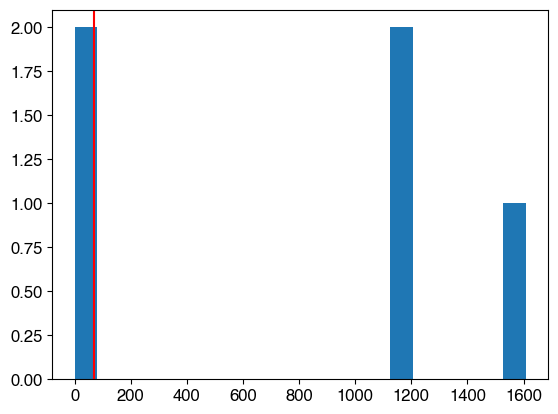

In [103]:
plt.hist(rois_nv, bins=20)
plt.axvline(x=ths_roi, color='red')

Text(0.5, 0, 'series 2 at time $s$')

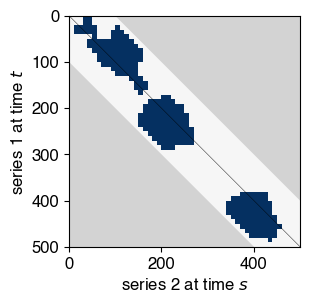

In [104]:
plt.figure(figsize=(3,3))
ldn.imshow(np.isin(rej_blobs, np.where(rois_nv > ths_roi)[0]), time=[rec_time[0], rec_time[1]], identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
plt.xlim(rec_time[0], rec_time[1]), plt.ylim(rec_time[1], rec_time[0])
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')


([], [])

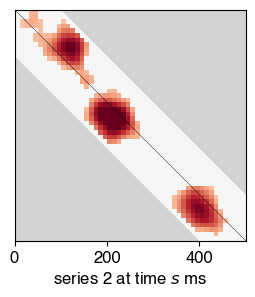

In [105]:
plt.figure(figsize=(3,3))
ldn.imshow(dspr_est[:num_time,num_time:] * np.isin(rej_blobs, np.where(rois_nv > ths_roi)[0]),
          vmax=0.0004, time=rec_time, identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
plt.xlim(rec_time[0], rec_time[1]), plt.ylim(rec_time[1], rec_time[0])
# plt.ylabel(r'series 1 at time $t$'); 
plt.xlabel(r'series 2 at time $s$ ms'); plt.yticks([],[])

In [106]:
np.mean(rois_nv <= mrois_nv_perm[:,None], 0)

array([1.  , 0.  , 0.  , 0.  , 0.75])

In [107]:
np.savez("result_simulation_11",
         Omega_est=Omega_est, Sigma_est=Sigma_est,
         Omegas_perm=Omegas_perm, Sigmas_perm=Sigmas_perm)

# 7. Factor Loading Animation

In [566]:
covs = [[np.cov(da) for da in dat] for dat in data]

In [567]:
loadings = [
    np.matmul(covs[0],np.reshape(weight_est[:num_time], (num_time,-1,1)))[...,0],
    np.matmul(covs[1],np.reshape(weight_est[num_time:], (num_time,-1,1)))[...,0]
]

In [568]:
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML

In [569]:
sigma = 0.5
weights = np.exp(-np.sum(np.square(
    np.mgrid[0:4:100j,0:4:100j][...,None]-coords_S[0].T[:,None,None,:]),
    0) / (2*sigma**2))

Text(0.5, 0, 't = 0.000sec.')

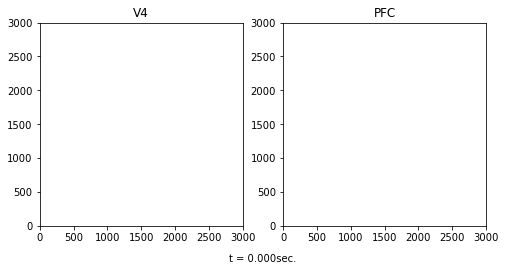

In [570]:
# First set up the figure, the axis, and the plot element we want to animate
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

ax1.set_title("V4"); ax2.set_title("PFC")
img1 = ax1.imshow([[]], cmap='RdBu', origin='lower', extent=((0,3000,0,3000)))
img2 = ax2.imshow([[]], cmap='RdBu', origin='lower', extent=((0,3000,0,3000)))

ax3 = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("t = %.3fsec."%0)

In [571]:
# initialization function: plot the background of each frame
def init():
    img1.set_data([[]]); img1.set_clim(-0.1,0.1)
    img2.set_data([[]]); img2.set_clim(-0.1,0.1)
    return (img1,img2)

In [572]:
# animation function. This is called sequentially
def animate(i):
    n = 0
    img1.set_data((np.sum(weights*loadings[0][i],-1)/np.sum(weights,-1)).T)
    img2.set_data((np.sum(weights*loadings[1][i],-1)/np.sum(weights,-1)).T)
    ax3.set_xlabel(r't=%.3fsec.'%((i-1)/100))
    return (img1,img2)

In [573]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames=50, interval=100, blit=True)

In [574]:
HTML(anim.to_html5_video())

In [575]:
fmt = {0.25: '.25', 0.5: '.50', 0.75: '.75'}

[Text(1, 0, '0'),
 Text(1, 0, '.25'),
 Text(1, 0, '.50'),
 Text(1, 0, '.75'),
 Text(1, 0, '1')]

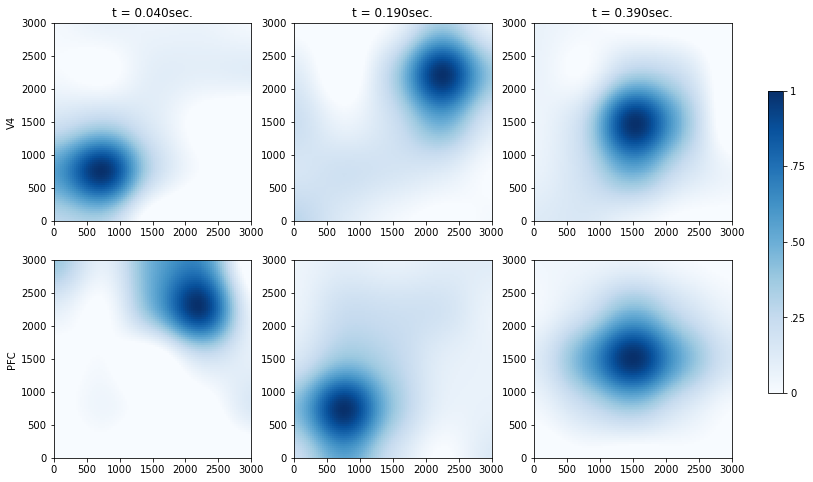

In [576]:
fig, (axes1, axes2) = plt.subplots(2, 3, figsize=(14,8))
tpts = [5, 20, 40]

for i, t in enumerate(tpts):
    (ax1,ax2) = (axes1[i], axes2[i])
    
    ax1.set_title("t = %.3fsec."%((t-1)/100))
    load_norm = [np.sum(weights*loading[t],-1)/np.sum(weights,-1)
                 for loading in loadings]
    zl = [(load/np.max(load)).T for load in load_norm]
    img1 = ax1.imshow(zl[0],
                      cmap='Blues', origin='lower', extent=((0,3000,0,3000)))
    img2 = ax2.imshow(zl[1],
                      cmap='Blues', origin='lower', extent=((0,3000,0,3000)))
    img1.set_clim(0,1)
    img2.set_clim(0,1)
    
#     ct1 = ax1.contour((np.arange(100)+0.5)*30, (np.arange(100)+0.5)*30,
#             zl[0], levels=[0.25, 0.5, 0.75], linewidths=0.2, colors=['black'])
#     ax1.clabel(ct1, ct1.levels, fmt=fmt, inline=True, fontsize=10)
#     ct2 = ax2.contour((np.arange(100)+0.5)*30, (np.arange(100)+0.5)*30,
#             zl[1],  levels=[0.25, 0.5, 0.75], linewidths=0.2, colors=['black'])
#     ax2.clabel(ct2, ct2.levels, fmt=fmt, inline=True, fontsize=10)
    
    if i == 0:
        ax1.set_ylabel("V4")
        ax2.set_ylabel("PFC")
        
fig.subplots_adjust(right=0.8)

ax_cb = fig.add_axes([0.75, 0.15, 0.1, 0.7])
ax_cb.axis('off')
cb = plt.colorbar(ax2.get_images()[0], ticks=[0, 0.25, 0.5, 0.75, 1])
cb.ax.set_yticklabels(['0','.25','.50','.75','1'])

# 8. Granger Causality

In [675]:
bw = 10
order = 5
lambda_reg = lambda_diag # 1.5
lags_cond = np.array([1,2])

In [676]:
GC_ar = np.zeros([num_time, 2])

In [677]:
for end_time in np.arange(bw, num_time):
    Sigma_tw = (Sigma_est.reshape([2,num_time,2,num_time])
        [:,end_time-bw:end_time,:,end_time-bw:end_time])

    Sigma_ar = np.mean([Sigma_tw[:,i+order:i:-1,:,i+order:i:-1] 
        for i in np.arange(bw-order)], 0).reshape((2*order,2*order))
    
    id_ar1 = np.concatenate([np.arange(order),lags_cond+order])
    id_ar2 = np.concatenate([np.arange(order)+order,lags_cond])
    id_ar12 = np.concatenate([np.arange(order),np.arange(1,order)+order])
    id_ar21 = np.concatenate([np.arange(order)+order,np.arange(1,order)])
    
    lcov_ar1 = Sigma_ar[np.ix_(id_ar1,id_ar1)]
    lcov_ar2 = Sigma_ar[np.ix_(id_ar2,id_ar2)]
    lcov_ar12 = Sigma_ar[np.ix_(id_ar12,id_ar12)]
    lcov_ar21 = Sigma_ar[np.ix_(id_ar21,id_ar21)]
    
    lcov_ar1 = lcov_ar1 + lambda_reg * np.eye(lcov_ar1.shape[0])
    lcov_ar2 = lcov_ar2 + lambda_reg * np.eye(lcov_ar2.shape[0])
    lcov_ar12 = lcov_ar12 + lambda_reg * np.eye(lcov_ar12.shape[0])
    lcov_ar21 = lcov_ar21 + lambda_reg * np.eye(lcov_ar21.shape[0])

    mse_ar1 = lcov_ar1[0,0] - lcov_ar1[0,1:]@np.linalg.inv(lcov_ar1[1:,1:])@lcov_ar1[0,1:]
    mse_ar2 = lcov_ar2[0,0] - lcov_ar2[0,1:]@np.linalg.inv(lcov_ar2[1:,1:])@lcov_ar2[0,1:]

    mse_ar12 = lcov_ar12[0,0] - lcov_ar12[0,1:]@np.linalg.inv(lcov_ar12[1:,1:])@lcov_ar12[0,1:]
    mse_ar21 = lcov_ar21[0,0] - lcov_ar21[0,1:]@np.linalg.inv(lcov_ar21[1:,1:])@lcov_ar21[0,1:]
    
    GC_ar[end_time] = (np.log(mse_ar1) - np.log(mse_ar12), 
                       np.log(mse_ar2) - np.log(mse_ar21))

## permutation bootstrap

In [678]:
num_perm = Sigmas_perm.shape[0]
GCs_perm = np.zeros([num_perm, num_time, 2])

In [679]:
for iter_perm in np.arange(num_perm):
    for end_time in np.arange(bw, num_time):
        Sigma_tw = (Sigmas_perm[iter_perm].reshape([2,num_time,2,num_time])
            [:,end_time-bw:end_time,:,end_time-bw:end_time])

        Sigma_ar = np.mean([Sigma_tw[:,i+order:i:-1,:,i+order:i:-1] 
            for i in np.arange(bw-order)], 0).reshape((2*order,2*order))

        id_ar1 = np.concatenate([np.arange(order),lags_cond+order])
        id_ar2 = np.concatenate([np.arange(order)+order,lags_cond])
        id_ar12 = np.concatenate([np.arange(order),np.arange(1,order)+order])
        id_ar21 = np.concatenate([np.arange(order)+order,np.arange(1,order)])

        lcov_ar1 = Sigma_ar[np.ix_(id_ar1,id_ar1)]
        lcov_ar2 = Sigma_ar[np.ix_(id_ar2,id_ar2)]
        lcov_ar12 = Sigma_ar[np.ix_(id_ar12,id_ar12)]
        lcov_ar21 = Sigma_ar[np.ix_(id_ar21,id_ar21)]

        lcov_ar1 = lcov_ar1 + lambda_reg * np.eye(lcov_ar1.shape[0])
        lcov_ar2 = lcov_ar2 + lambda_reg * np.eye(lcov_ar2.shape[0])
        lcov_ar12 = lcov_ar12 + lambda_reg * np.eye(lcov_ar12.shape[0])
        lcov_ar21 = lcov_ar21 + lambda_reg * np.eye(lcov_ar21.shape[0])

        mse_ar1 = lcov_ar1[0,0] - lcov_ar1[0,1:]@np.linalg.inv(lcov_ar1[1:,1:])@lcov_ar1[0,1:]
        mse_ar2 = lcov_ar2[0,0] - lcov_ar2[0,1:]@np.linalg.inv(lcov_ar2[1:,1:])@lcov_ar2[0,1:]

        mse_ar12 = lcov_ar12[0,0] - lcov_ar12[0,1:]@np.linalg.inv(lcov_ar12[1:,1:])@lcov_ar12[0,1:]
        mse_ar21 = lcov_ar21[0,0] - lcov_ar21[0,1:]@np.linalg.inv(lcov_ar21[1:,1:])@lcov_ar21[0,1:]

        GCs_perm[iter_perm,end_time] = \
            (np.log(mse_ar1) - np.log(mse_ar12), 
             np.log(mse_ar2) - np.log(mse_ar21))

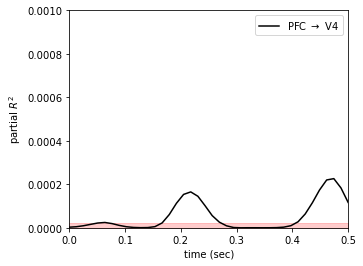

In [682]:
plt.figure(figsize=(5,4))
plt.plot(np.linspace(0,0.5,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
         GC_ar[bw:,0], label=r'PFC $\rightarrow$ V4', color='black')
plt.fill_between(
    np.linspace(0,0.5,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
    np.quantile(np.max(GCs_perm[:,bw:,0],0.99,0),
    color='red', alpha=0.2)
# plt.fill_between([0,50],[0.001,0.001],color='grey',alpha=1)
# plt.fill_between([450,500],[0.001,0.001],color='grey',alpha=1)
plt.ylim(0, 0.001); plt.xlim(0, 0.5)
plt.ylabel(r"partial $R^2$"); plt.xlabel("time (sec)"); plt.legend()
# plt.title(r"Granger Causality from PFC to V4")

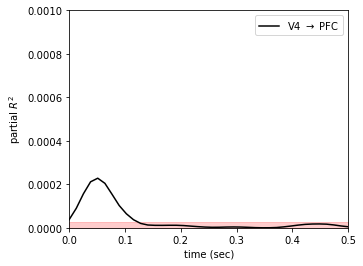

In [683]:
plt.figure(figsize=(5,4))
plt.plot(np.linspace(0,0.5,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
         GC_ar[bw:,1], label=r'V4 $\rightarrow$ PFC', color='black')
plt.fill_between(
    np.linspace(0,0.5,num_time-bw),
    # np.arange(num_time-bw)*5+bw*2.5,
    np.quantile(np.max(GCs_perm[:,bw:,1],0),0.99,0),
    color='red', alpha=0.2)
# plt.fill_between([0,50],[0.001,0.001],color='grey',alpha=1)
# plt.fill_between([450,500],[0.001,0.001],color='grey',alpha=1)
plt.ylim(0, 0.001); plt.xlim(0, 0.5)
plt.ylabel(r"partial $R^2$"); plt.xlabel("time (sec)"); plt.legend()
# plt.title(r"Granger Causality from V4 to PFC")

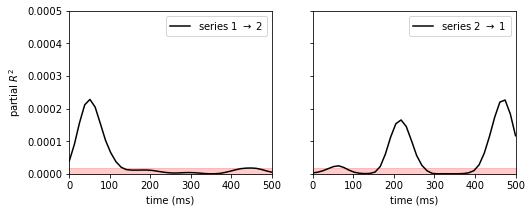

In [696]:
plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.plot(np.linspace(0,500,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
         GC_ar[bw:,1], label=r'series 1 $\rightarrow$ 2', color='black')
plt.fill_between(
    np.linspace(0,500,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
    np.quantile(np.max(GCs_perm[:,bw:,0],1),0.95,0),
    color='red', alpha=0.2)
# plt.fill_between([0,50],[0.001,0.001],color='grey',alpha=1)
# plt.fill_between([450,500],[0.001,0.001],color='grey',alpha=1)
plt.ylim(0, 0.0005); plt.xlim(0, 500)
plt.ylabel(r"partial $R^2$"); plt.xlabel("time (ms)"); plt.legend()
# plt.title(r"Granger Causality from PFC to V4")

plt.subplot(1,2,2)
plt.plot(np.linspace(0,500,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
         GC_ar[bw:,0], label=r'series 2 $\rightarrow$ 1', color='black')
plt.fill_between(
    np.linspace(0,500,num_time-bw),
    # np.arange(num_time-bw)*5+bw*2.5,
    np.quantile(np.max(GCs_perm[:,bw:,1],1),0.95,0),
    color='red', alpha=0.2)
# plt.fill_between([0,50],[0.001,0.001],color='grey',alpha=1)
# plt.fill_between([450,500],[0.001,0.001],color='grey',alpha=1)
plt.ylim(0, 0.0005); plt.xlim(0, 500)
plt.ylabel(r""); plt.xlabel("time (ms)"); plt.legend()
plt.tick_params('y', labelleft=False)